In [3]:
%matplotlib inline

In [4]:
# The following code is necessary for animated matplotlib videos
# Based on http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
# and on http://nbviewer.ipython.org/gist/edrex/9044756
# Important: The ffmpeg library needs to be installed to make this work http://www.ffmpeg.org/
from matplotlib import animation, pyplot as plt

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

# a bit ugly to use a global variable here
fps = 10
def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        anim.save("tmp.mp4", fps=fps, extra_args=['-vcodec', 'libx264'])

        video = open("tmp.mp4","rb").read()
    plt.close()

    anim._encoded_video = video.encode("base64")
    return VIDEO_TAG.format(anim._encoded_video)

animation.Animation._repr_html_ = anim_to_html

# Bayesian inference

This tutorial provides a short introduction to Bayesian inference.

In general, statistical inference is the process of determining properties of a model/distribution given some data. Bayesian inference can be seen as the Bayesian counterpart to frequentist inference. In frequentist inference,
there is usually the notion of some true, unknown, parameter which is a constant and point estimates are inferred from data.
Contrary, Bayesian inference treats the model parameters as random variables and usually wants to deduce probabilistic statements about the distribution of parameters. For a more thorough discussion about the differences between frequentist and Bayesian statistics, please refer to the following blog post: http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/

Bayesian inference utilizes the famous Bayes rule:

$$
 P(A|B) = \frac{P(B | A) P(A)}{P(B)}
$$

For model based inference, we can replace $A$ with the parameters $\theta$ and $B$ with the data $D$ at interest. Furthermore, we can introduce $I$ which can be used to introduce an additional assumption (knowledge) to the inference such as which model to use.

$$
 \overbrace{P(\theta| D, I)}^{\text{posterior}} = \frac{\overbrace{P(D | \theta, I)}^{\text{likelihood}}\overbrace{P(\theta|I)}^{\text{prior}}}{\underbrace{P(D|I)}_{\text{marginal likelihood}}}
$$

The prior distribution $P(\theta|I)$ specifies our assumption about the parameters $\theta$  before taking the data into account. The likelihood $P(D | \theta, I)$ represents the probability of the data if the parameters $\theta$ are specified. The marginal likelihood (or evidence) $P(D|I)$ is the distribution of the data $D$ given our additional assumption $I$. It is the normalization of the Bayes rule and plays an important rule for model comparison. Finally, the posterior $P(\theta| D, I)$ is the distribution of the parameters after taking the observed data $D$ and our additional (prior) assumption $I$ into account. We can also say that the posterior is proportional to the likelihood and the prior.

$$
posterior \propto likelihood \times prior
$$

## Example: coin flip

### Introduction

For better understanding of Bayesian inference let us consider the classic coin flip example.

We are observing whether a coin flip results in "heads" or "tails". We are not sure whether the coin at interest is fair or whether it might be biased due to some asperity or similar things. Thus, we want to conduct statistical inference of the parameter $p$, which should describe the probability of flipping "heads", by utilizing the Bayesian framework. The probability of flipping "tails" is simply $1-p$. Further, we consider a set of observations $D$ by flipping the coin several times. Thus, by applying Bayes inference, we want to determine:

$$
P(p|D) \propto P(D|p) \times P(p)
$$

### Model

As underlying model, we can use the binomial distribution which is a discrete probability distribution for the number of successes in a sequence of n independent binary experiments (e.g., coin flips resulting in "heads" or "tails"). The binomial distribution is conditioned on the parameters $n$ (number of trials) and $p$ the probability of flipping "heads". The probability mass function of the binomial distribution---which determines the probability of observing $k$ "heads" with parameters $p$ and $n$---is defined as:

$$
f(k|p,n) = \binom nk p^k (1-p)^{n-k}
$$
We can rewrite above Bayes rules as:

$$
P(p|k,n) \propto P(k|p,n) \times P(p)
$$

### Prior

We know how we can calculate the likelihood based on the PMF of the binomial distribution. But, how can we now use the prior? As mentioned, the prior is our belief in the parameter(s) before observing the data. So basically, we can express our assumption about the parameter $p$ in our model in the form of another probability distribution. In case of the binomial distribution as likelihood, we can use the Beta distribution as a  <a href="https://en.wikipedia.org/wiki/Conjugate_prior">conjugate prior</a>. This means that also the posterior distribution will be of the same family (i.e., Beta distribution) as the prior distribution.

The beta distribution is a continuous probability distribution over the interval $[0,1]$. The PDF of the Beta distribution is defined as:

$$
f(x|\alpha,\beta) =  \frac{1}{B(\alpha,\beta)} x^{\alpha-1}(1-x)^{\beta-1} =  \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\, x^{\alpha-1}(1-x)^{\beta-1}
$$

$B$ is the <a href="https://en.wikipedia.org/wiki/Beta_function">beta function</a> and is a normalization constant to ensure that the probability integrates to 1. $\Gamma$ is the <a href="https://en.wikipedia.org/wiki/Gamma_function">gamma function</a>.

$\alpha$ and $\beta$ are positive shape parameters controlling the shape of the distribution. If they are $>=1$, we can think of them as pseudo counts; i.e., counts before observing the data. So for our example, this would mean that $\alpha$ would specify the pseudo counts of observing a "heads" flip, while $\beta$ would refer to the counts of observing a "tails" flip. The Wikipedia page of the <a href="https://en.wikipedia.org/wiki/Beta_distribution#Shapes">Beta distribution</a> goes into detail about the behavior of the shape parameters.

For a better understanding, let us visualize some examples next for the case of $\alpha >= 1$ and $\beta >= 1$. 

In [5]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

# helper function for plotting
def plot_beta(a,b,ax, print_interval=True):
    ax.set_xlabel("p")
    ax.set_ylabel("probability density")
    x = np.linspace(0.00,1, 100)
    label = "$\\alpha= " + str(a) + ", \\beta=" + str(b) + "$"
    dist = beta(a,b)
    # plot density
    ax.plot(x, dist.pdf(x),
            lw=2, alpha=0.6, label=label)
    # determine the 95% HDI
    if print_interval:
        print "Interval containing 95% of the distribution: ", dist.interval(0.95)

Let us consider a symmetric Beta distribution. This means that we want to express our prior belief that the coin is fair. We can express this prior with the shape parameters $\alpha$ and $\beta$ which we can interpret as pseudo counts. As we have a fair belief, we set both shape parameters to the same value. Let us start with $\alpha=\beta=10$.

Interval containing 95% of the distribution:  (0.2886432479169988, 0.7113567520830012)


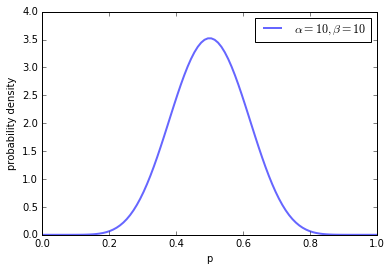

In [6]:
fig, ax = plt.subplots(1,1)
plot_beta(10,10,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

What we can see is the PDF of the Beta distribution with our given shape parameters. We can see that the parameter $p=0.5$ receives the highest density. However, as we keep our pseudo counts relatively low, we also allow other parameter configurations to receive a certain density. If we determine the interval containing 95% of the distribution, we receive $0.29$ as the lower and $0.71$ as the upper boundary.

Interval containing 95% of the distribution:  (0.43095093094181675, 0.56904906905818331)


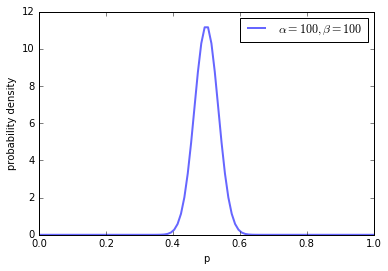

In [7]:
fig, ax = plt.subplots(1,1)
plot_beta(100,100,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

If we increase our symmetric shape parameters to a value of $100$, we can see a much higher density for parameters around the fair probability of $0.5$. The 95% highest density interval now lies between $0.43$ and $0.71$.

Interval containing 95% of the distribution:  (0.47809471962068506, 0.52190528037931494)


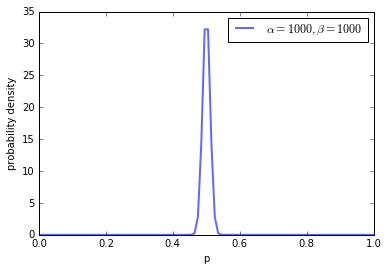

In [8]:
fig, ax = plt.subplots(1,1)
plot_beta(1000,1000,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

By further increasing the pseudo counts, we can further increase our "fair" coin belief.

Next, let us also shortly consider non-symmetric shape parameters (but let us still follow the pseudo count interpretation and thus, only use parameters larger than one).

Interval containing 95% of the distribution:  (0.69150289218123928, 0.99747142145553824)


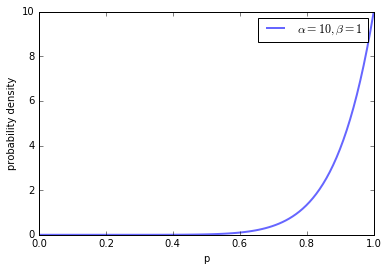

In [9]:
fig, ax = plt.subplots(1,1)
plot_beta(10,1,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

Setting $\alpha=10$ and $\beta=1$ increases the belief in an unfair coin biased towards flipping "heads". Finally, let us shortly consider what happens when we set $\alpha=\beta=1$.

Interval containing 95% of the distribution:  (0.025000000000000022, 0.97499999999999998)


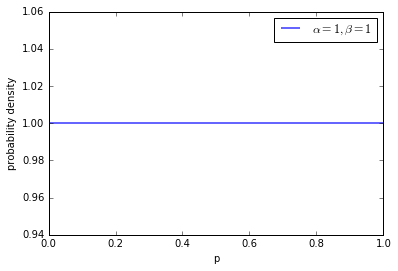

In [10]:
fig, ax = plt.subplots(1,1)
plot_beta(1,1,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

We can see that we now have a flat prior, meaning that all parameter configurations are equally likely. I suggest to play around with the shape parameters to see what happens with other configurations; also try to set the parameters lower than one.

### Posterior / Model fitting

Now that we have specified the likelihood-distribution as well as the prior-distribution we can rewrite the posterior-distribution as:

$$
P(p|k,n,\alpha,\beta) = \text{Beta}(p|\alpha+k, \beta+(n-k))
$$

As mentioned earlier, the posterior is from the same distribution family (Beta) as the prior (Beta), if the prior distribution is the conjugate prior to the likelihood distribution (binomial). For details about the derivation of this closed form of the posterior, please refer to this <a href="http://www.cs.cmu.edu/~10701/lecture/technote2_betabinomial.pdf">article</a>.

Thus, based on our Bayesian inference, the posterior distribution of the parameter $p$ indicating the probability of flipping "heads", is expressed as a Beta distribution. The parameters of this Beta distribution are constituted by both our a-priori assumptions---i.e., the hyperparameters $\alpha$ and $\beta$---as well as observed data---i.e., the number of times we flipped "heads" $k$ and "tails" $n-k$. The resulting posterior can then be used as a new prior as we gather more data.

For demonstrating how the posterior now changes with an increasing number of observations, let us assume that we know the parameter of flipping "heads" in advance---i.e., we manually assume $p$ of the binomial distribution to be $0.4$. For simplicity, let us assume that our inital Beta prior has the hyperparameters $\alpha=\beta=1$ meaning that we have no real a-priori tendency and work with a flat prior---this can be seen as an "anything is possible prior". Next, we incrementally sample single random variates from the binomial distribution with $p=0.4$ (Bernoulli trials) and update our posterior with corresponding samples.

In [11]:
# the animations only work for me in Chrome
from scipy.stats import beta, binom

# initializing plot
def init_plot():
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 1), ylim=(0, 13))
    line, = ax.plot([], [], lw=2)
    ttl = ax.text(0.6,0.8,'', transform = ax.transAxes, va='center', size=20)
    ax.set_xlabel("p")
    ax.set_ylabel("probability density")
    return fig, ax, ttl, line

# random variates
samples = binom.rvs(1,0.4, size=200)

# starting parameters and x values
a = 1
b = 1
x = np.linspace(0.00,1, 100)

# init function
def init():
    ttl.set_text("$\\alpha= " + str(a) + ", \\beta=" + str(b) + "$")
    y =  beta.pdf(x,a,b)
    line.set_data(x,y)
    return line,

# animating the stuff
def animate(i):
    global a,b
    # somehow the init frame is not drawn, so a small hack here
    if i != 0:
        a += samples[i-1]
        b += 1 - samples[i-1]
    ttl.set_text("$\\alpha= " + str(a) + ", \\beta=" + str(b) + "$")
    y =  beta.pdf(x,a,b)
    line.set_ydata(y)
    return line,

# let's animate
# you can increase/decrease the FPS at the beginning of this notebook
fig, ax, ttl, line = init_plot()
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=1, blit=True)

In above animation, we can see that with an increasing amount of random samples from the binomial distribution, starting with an initial uniform (flat) belief (prior), we increasingly belief in the true parameter (i.e., $p=0.4$) from the underlying distribution that we manually specified beforehand. Bayesian inference not only allows us to make statements about the most probable values for $p$, but also about the credibility of these statements (highest density regions).

What happens though, if we have stronger beliefs a-priori? Let us specify a Beta prior with $\alpha=50$ and $\beta=10$. Hence, we have decently high belief in a biased coin towards "heads", while our binomial distribution is slightly biased towards "tails" with $p=0.4$.

In [12]:
fig, ax, ttl, line = init_plot()
a = 50
b = 10
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=1, blit=True)

We can see, that with our 200 samples, our highest posterior belief is around $p=0.5$. This indicates the influence of the prior. Actually, the posterior can be seen as a convex combination of prior belief (pseudo counts) and the data ("heads" and "tails" counts). If our prior belief is strong, we need more data to "overrule" the prior. 

However, if we "steer" our prior in the right direction, we can increase our credibility around the "true" parameter, much faster.

In [13]:
fig, ax, ttl, line = init_plot()
a = 4
b = 6
animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=1, blit=True)

You can play around with the parameters here. I also suggest to increase the prior pseudo counts to large numbers which results in the necessity to sample many variates to see differences regarding your prior knowledge (this may take a while though).

To summarize, with Bayesian inference and model fitting, we "learn" the posterior making probabilistic statements about the parameter(s) at interest based on prior intuitions and observed data. In contrast, frequentist statistics, would make points estimates, e.g., by maximum likelihood estimation (MLE).

### Credible intervals

Having fitted the model, we regularly want to get an interval for the true population mean. In frequentist statistics, these intervals are called "confidence intervals". Remember that in frequentist statistics the idea is that there is a true, fied unknown population parameter and the data is random. Then, the idea is to derive the confidence interval from a sample so that we can state that an interval constructed this way will contain the true parameter e.g., 95% of times. Hence, with confidence intervals, we can only make probabilistic statements about the interval, not the parameter. We cannot say that the interval contains the true parameter with 95% probability.

In contrast, Bayesian credible intervals allow for these kind of probabilistic statements about the parameter. They can be constructed very intuitively directly from the posterior by deriving e.g., the 95% highest density interval. Then, we can say that constructed interval contains the parameter with 95% probability. 

Again, I want to mention the excellent blog post series by Jake Vanderplas discussing these differences in greater detail: http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/

So, as an example, say we use a flat Beta prior with $\alpha=1$ and $\beta=1$ and observe $80$ heads and $120$ tails. Then, we can simply derive the 95% credible interval from the posterior:

In [14]:
dist = beta(1+80,1+120)
print "95% Credible interval:", dist.interval(0.95)

95% Credible interval: (0.33457527271671478, 0.46926229727939239)


### Hypothesis testing

Another very common task in statistical inference, is the task of doing hypotheses testing. In our example, a common hypotheses to test would be "The coin is fair!".

In frequentist, statistics, this is usually tackled by null hypotheses significance test, where we try to reject a null hypothesis. With this approach, we can only reject or not reject the null hypothesis though, but never accept it. A simple way of doing that, would be to do a binomial test, where we set our null hypothesis as the coin being fair by setting $p=0.5$.

In [15]:
binom.cdf(80,200,0.5)

0.0028425779983751133

Here, the p-value would be below a significance level of $0.01$ clearly rejecting the null hypothesis that the coin is fair.

In Bayesian statistics, there are some ways of doing hypotheses testing. In this notebook, I want to elaborate the most trivial, but also clearest method first. This method is concerned with simply evaluating the posterior. After all, the posterior provides probabilistic statements about the parameter. So again, setting $\alpha=1$ and $\beta=1$ and observing $80$ heads and $120$ tails, we fit the model and end up with the following Beta posterior: 

Interval containing 95% of the distribution:  (0.33457527271671478, 0.46926229727939239)


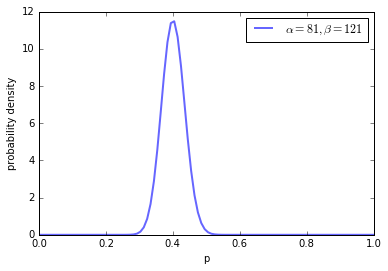

In [16]:
fig, ax = plt.subplots(1,1)
plot_beta(81,121,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

Now, we can directly examine the posterior and check the posterior probability for the null hypothesis parameter $p=0.5$. Just by looking at the graphical output, we can see that $p=0.5$ does not receive much posterior probability. So we could probably reject the hypothesis.

However, in practise only saying that a coin is fair if it is exactly $p=0.5$ is a bit illusional. Thus, John Kruschke [1], suggests to use so-called regions of practival equivalence (ROPE) for the null hypothesis. This simply means that you give the null hypothesis some kind of tolerance.

For example, for a fair coin hypothesis, we could set the ROPE to [0.45, 0.55]. Then, we check whether the ROPE interval falls into the 95% credible interval [0.33, 0.47]. It indeed does partly, so we probably would not fully reject the null hypothesis, but we can be pretty sure, that the coin is not fair. Note that with more samples (data), the credible interval would then probably be more dense, which would lead to a possible clear rejection.

[1] Kruschke, John. Doing Bayesian data analysis: A tutorial with R, JAGS, and Stan. Academic Press, 2014

Another way of doing hypothesis tests, is to use the marginal likelihood which we have not talked about much yet.

Let us re-iterate Bayesian inference:

$$
 \overbrace{P(\theta| D, I)}^{\text{posterior}} = \frac{\overbrace{P(D | \theta, I)}^{\text{likelihood}}\overbrace{P(\theta|I)}^{\text{prior}}}{\underbrace{P(D|I)}_{\text{marginal likelihood}}}
$$

$\theta$ corresponds to the parameters of the binomial model, $D$ are the coin flips at interest and $I$ corresponds to additional information (e.g., a model or a hypothesis). 

The <a href="https://en.wikipedia.org/wiki/Marginal_likelihood">marginal likelihood</a> corresponds to the probability of the data where the parameters have been marginalized out:

$$
P(D | I) = \int P(D | \theta, I)P(\theta | I)d\theta
$$

The evidence is the weighted average over all possible values of the parameters $\theta$ where the weights come from the prior. So basically, the marginal likelihood is an average of the likelihood weighted by the prior.

Generally, we can say that if the prior is well aligned with the data,
then the evidence is rising with the strength of the prior. The evidence
is the largest if the prior and the likelihood are concentrated over
the same parameter regions and it is the lowest if they concentrate
on different regions.

For comparing the plausibility of two models, we can resort to <a href="https://en.wikipedia.org/wiki/Bayes_factor">Bayes factors</a>. 
Bayes factors are representing a Bayesian method for model comparison that include a natural Occam's razor guarding against overfitting.  We can define the Bayes factor---note that we apply unbiased comparison assuming that all models are equally likely a priori---as follows:

$$
B_{1,2} = \frac{P(D | M_1)}{P(D|M_2)}
$$

The strength of a Bayes factor can be determined by consulting the <a href="https://en.wikipedia.org/wiki/Bayes_factor#Interpretation">interpretation tables</a> of Jeffrey or Kass and Raftery.

Instead of comparing models, we can now also compare hypotheses encoded in the form of priors. For example, for the null hypothesis of a fair coin, we could use a Beta prior with $\alpha=100$ and $\beta=100$. The stronger be believe in this hypothesis, the higher we would set the overall concentration of the Beta prior, e.g., $\alpha=1000$ and $\beta=1000$. This is a similar idea to the ROPE discussed above, with rising symmetric concentration, we would at one point only believe in $p=0.5$ without any tolerance. As an alternative hypothesis, we could use an "anything is possible" prior with $\alpha=1$ and $\beta=1$.

For the binomial model with a conjugate Beta prior, the marginal likelihood is defined as follows,

$$
P(D) = {{n}\choose{k}}\frac{B(k+\alpha,n-k+\beta)}{B(\alpha,\beta)}
$$

where $B()$ is the <a href="https://en.wikipedia.org/wiki/Beta_function">Beta function</a>.

Then, for alternative hypotheses $H_{null}$ and $H_{alt}$, the Bayes factor is defined as:

$$
\frac{P(n,k|H_{alt})}{P(n,k|H_{null})} = \frac{{{n}\choose{k}}\frac{B(k+\alpha_{alt},n-k+\beta_{alt})}{B(\alpha_{alt},\beta_{alt})}}{{{n}\choose{k}}\frac{B(k+\alpha_{null},n-k+\beta_{null})}{B(\alpha_{null},\beta_{null})}}
$$

The binomial coefficient cancelc out, and we can calculate the Bayes factor:

In [17]:
# for tractability work with the logarithm
from scipy.special import betaln

p_alt = betaln(80+1,120+1) - betaln(1,1)
p_null = betaln(80+100,120+100) - betaln(100,100)

bf = p_alt - p_null
print "Log Bayes factor: ", bf

Log Bayes factor:  -0.0815254597165


Okay, interestingly the Bayes factor tells us to support the null hypothesis instead of the alternative hypothesis here. This is not surprising if we plot the null hypothesis and alternative.

Interval containing 95% of the distribution:  (0.43095093094181675, 0.56904906905818331)


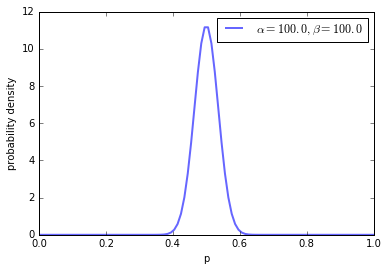

In [18]:
fig, ax = plt.subplots(1,1)
plot_beta(100.,100.,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

Interval containing 95% of the distribution:  (0.025000000000000022, 0.97499999999999998)


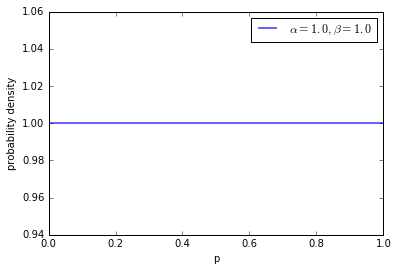

In [19]:
fig, ax = plt.subplots(1,1)
plot_beta(1.,1.,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

What we can see is that we allow our null hypothesis quite some tolerance here around $p=0.5$ and we know from our previous studies that fitting the data results in a posterior centered around $p=0.4$. Contrary, the flat prior gives equal probability to all possible parameter values. Thus, the marginal likelihood is higher for the alternative hypothesis, as it better captures the data. 

However, if we narrow our tolerance for the fair coin down, e.g., by setting $\alpha=1000$ and $\beta=1000$, we end up with different results.

Interval containing 95% of the distribution:  (0.47809471962068506, 0.52190528037931494)


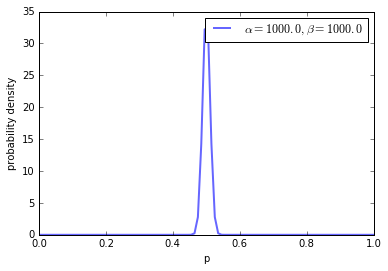

In [20]:
fig, ax = plt.subplots(1,1)
plot_beta(1000.,1000.,ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

In [21]:
# for tractability work with the logarithm
from scipy.special import betaln

p_alt = betaln(80+1,120+1) - betaln(1,1)
p_null = betaln(80+1000,120+1000) - betaln(1000,1000)

bf = p_alt - p_null
print "Log Bayes factor: ", bf

Log Bayes factor:  1.263500964


Now, we have a preference (even though only a small one) for the alternative hypothesis which would state that the coin is not fair. 

These results demonstrate, that the prior can encode hypothesis and we can then utilize the marginal likelihood and Bayes factors for comparing hypothesis. However, this is very much influenced by the choice of prior. But, similar to ROPEs, we can give hypothesis tolerance levels, allowing us to not make strict statements about hypothesis. Usually, I would advise to play around with the overall concentration/tolerance and observe the behavior of the Bayes factor for making judgements about hypotheses.

In general, I think Bayesian statistics allows for more intuitive hypotheses tests, also allowing us to make probabilistic statements about the hypotheses themselves in form of tolerance levels.

A more detailed discussion about this, is also provided in John Kruschkes book [1].

### Prediction

Finally, having our model, we also want to do prediction. For that, we refer to our fitted model. In frequentist statistics, we would simply take our MLE point estimate for that task. So, again for our example with $80$ Heads and $120$ Tails, if we would like to know the probability of observing unseen data, e.g., $1$ Heads, we would calculate:

In [22]:
print (80/200.)**1

0.4


For $10$ Heads out of 10 flips this would mean:

In [23]:
print (80/200.)**10

0.0001048576


In Bayesian inference, instead of using point estimates, we use our probabilistic statements about the parameter from the posterior for making prediction. This is usually refered to as <a href="https://en.wikipedia.org/wiki/Posterior_predictive_distribution">posterior predictive distribution</a>. This is the distribution of unobserved data, conditioned on observed data and prior. It follows the exact same idea as the marginal likelihood discussed above (which can be seen as a prior predictive distribution), namely that we want to evaluate new data on our fitted model. We can write the posterior predictive distribution as,


$$
P(x |D, I) = \int P(x|\theta)P(\theta |D, I)d\theta
$$

where $D$ refers to our training data, and $x$ to some new unseen data.

For our beta-binomial model, we can write,

$$
P(j | m,k,n,\alpha,\beta) = \int 
P(j|m,\theta)P(\theta |k,n,\alpha,\beta)d\theta= \binom{m}{j} \frac{B(k+j+\alpha,n-k+m-j+\beta)} {B(\alpha+k,\beta+n-k)}
$$

where $j$ refers to the new number of Heads, $m$ to the new number of total flips, $k$ to the previous number of Heads, $n$ to the previous number of total flips, and $\alpha$ and $\beta$ to our prior hyperparameters.

So, for our previous examples, this results in, e.g.,:

$$
P(1 | 1,80,200,1,1) = \binom{1}{1} \frac{B(80+1+1,200-80+1-1+1)} {B(1+80,1+200-80)}
$$

In [24]:
pp = betaln(80+1+1,200-80+1) - betaln(81,121)
print np.exp(pp)

0.40099009901


Or for flipping $10$ times Heads out of $10$ new flips:

In [25]:
pp = betaln(80+10+1,200-80+1) - betaln(81,121)
print np.exp(pp)

0.000147376315517


Pretty similar results to the frequentist ones above, but this time we evaluate the new data on the whole posterior.

In case of predicting new data points, one could just use those with highest posterior predictive probability.

Similar to frequentist statistics, Bayesian inference also allows to work with points estimates directly derived from the posterior; for example, by taking the posterior mean, median or mode (<a href="https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation">maximum a posteriori estimate MAP</a>). 